**This code computes the decomposed solution of a Closed-Loop DRTO problem and compares it with the monolithic solution.**

- The model is the nonlinear version of the bioreactor of Case Study 2 from:*Gao, Ling. "Modeling and dynamics analyses of immobilized CSTR bioreactor using transfer function model." 2012 International Symposium on Information Technologies in Medicine and Education. Vol. 2. IEEE, 2012.*
- The underlying control structure (modeled in the CLDRTO model) contains one constrained MPC, which is represented by its KKT conditions in the DRTO problem. The complementarity constraints of the MPC are "moved" to the objective function as a  l1 penalty
- The problem is posed as a scenario-based stochastic programming problem
- The uncertainty represented by the scenarios comes from the the maximum reaction rate (Vm) 

--> see jupyter notebook "Preliminaries" for details

AUTHOR: Jose Matias <assumpcj@mcmaster.ca> <br>
DATE: September 2023

[1.Model and Simulation Parameters](#sec1) <br>
[2.Building Auxiliary Functions](#sec2)<br>
[2.1. MPC matrices builder](#subsec21)<br>
[2.2. Monolithic CLDRTO](#subsec22)<br>
[2.3. Decomposed CLDRTO](#subsec23)<br>
[3. Comparing performance when # of scenarios increase](#sec3)<br>
[4. Comparing trajectories computed by monolhitic and decomposed](#sec4)<br>

In [1]:
using LinearAlgebra, JuMP, Ipopt, Plots, CSV, DataFrames, LaTeXStrings, Distributions, Random

<a id="sec1"></a>

# Model and Simulation Parameters

- Simulation Parameters

In [2]:
# Simulation sampling time
dt = 1.0 #[h]

# Optimization horizon 
ndrto = 20 + (8 - 1) # p = 8 *controller horizon

# Optimization control horizon 
mD = 20 

# Optimization horizon
Δdrto = 4 # dt_DRTO

# integration (BE) sampling time
n_fe_dt = 5 # number of finite elements/simulation sampling time 

# finite element length
h = dt/n_fe_dt 

# number of finite elements 
nfe = ndrto*n_fe_dt

# Set seed value for choosing the plant parameter 
seed = 42
Random.seed!(seed)

# number of inputs
nu = 1 #[-]
# number of outputs
ny = 1 #[-]
# number of states
nx = 2 # [-]

# INITIAL CONDITION (from paper)
C0 = 0.358 #[g/L]
P0 = 0.642 # [g/L]

# States (algebraic and differential): C, P
x0 = [C0,P0]

# INPUTS (from paper)
Cin0 = 1 #[g/L]
u0 = Cin0;

- Model Parameters

In [3]:
# maximum reaction rate (NOTE CHANGE IN PARAMETERS FROM LINEAR)
Vm_nom = 0.75 # [1/h]

# reaction constant (inhibition parameter)
Ks = 0.5 # [g/L]

# Dilution rate ==> D = F/V, Fbar = 2 [L/h], V = 4 [L] 
D = 0.5; # [1/h] 

In [4]:
# Uncertain parameters: Vm 
# nominal value
pNom = 0.75
# standard deviation associated with uncertainty (\pm 20%)
deltaPar = 0.2*pNom; 

- Economic Optimization Problem Parameters

In [5]:
# feed concentration limitation  (2.0 vs. 5.0)
Cin_max = 5.0 #[g/L] 

# product setpoint limitation
Psp_max = 1.2 # [g/L]

# Soft upper bounds on P weight
pUB = 1.05 # [g/L]

# objective function weight for P penalization term 
wP = 100

# Objective function: target tracking
pTrack = 1.0 # [g/L]

# setting bounds (all arbitrary - not in deviation form!!) 
uMax = 5.0 # [g/L] (linear = 2.4)
uMin = 0.0

yspMax = 1.2 # [g/L]
yspMin = 0.0;

- MPC Parameters

In [6]:
##########
# MODELS #
##########
# Linearization point
uref = 1.0
xref = [0.3660;0.6340]
yref = 0.6340

# 100 pre-computed models based on parametric uncertainty Vm (computed using matlab: BioReactorLinearization.m)
bioModels = CSV.read("C:\\Users\\MACC-Jose\\Documents\\GitHub\\BD\\CLDRTO Case Study 3 - Bioreactor (nonlinear)\\BioreactorModel", DataFrame; header=false);
#print(bioModels)

# extracting the matrices from the model array computed previously
nNom = 50 # nominal model --> index = 50

A = Matrix(bioModels[2*(nNom - 1) + 1:2*(nNom - 1) + 2,1:2]) 
B = bioModels[2*(nNom - 1) + 1:2*(nNom - 1) + 2,3]
C = [0 1];

# initial value of xMPC
xMPC0 = x0 - xref
de0 = 0

##########
# TUNING #
##########
# prediction horizon 
p = 8

# control horizon 
m = 2

# output tracking weight
q = 1

# move supression weight
r = 1

# input bounds (not in deviation form)
u_mpc_lb = 0.0
u_mpc_ub = Cin_max

##################
# KKT CONDITIONS #
##################
# matrix to compute the gradients of the input bound constraints
conMatrix = [-I(m); I(m)];

- Preparing Orthogonal Collocation

In [7]:
# Parameters for orthogonal collocation
#  Radau Collocation Points 1st degree polynomial == Backward Euler
radau  = [0.0 1.00000]

# number of collocation points (initial point is also considered)
ncp = length(radau) 

# Collocation parameters and radau time series
colmat = [-1.0 -1.0;
          1.0 1.0];        

- Bender's Decomposition

In [8]:
# max number of iteration (50)
benIterMax = 150

# optimality gap (relative) tolerance (1e-2)
optGap = 1e-3

# parameter that weights the nominal trajectory tracking term (1e-2)
η_n = 0.0;

<a id="sec2"></a>

# Building auxiliary functions

<a id="subsec21"></a>

## MPC matrices builder

In [9]:
function MPC_matrices(A,B,C,p,m,q,r)
    ###########
    # inputs: #
    ###########
    # A,B,C - System model
    # p, m - prediction and control horizon
    # q, r - setpoint and input usage tuning parameters
    
    # extracting dimensions from system model
    nx = size(A,1) # states
    nu = size(B,2) # inputs
    ny = size(C,1) # outputs
    
    # adding disturbance model
    Ad = [A zeros(nx,ny); zeros(ny,nx) I(ny)]
    Bd = [B; zeros(ny,nu)]
    Cd = [C ones(ny,ny)]
    
    # building matrices for MPC
    Psi = Cd*Ad
    for ii in 2:p
        Psi = [Psi;  Cd*Ad^ii]
    end

    # Computing Dynamic Matrix
    a = Cd*Bd
    for ii in 2:p
        a = [a; Cd*Ad^(ii - 1)*Bd]
    end
    DynM = a

    for ii in 1:(m - 2)
        a = [zeros(ny,nu);a[1:(p-1)*ny,:]]
        DynM = [DynM  a]
    end

    # adjusting dynamic matrix for since p > m (last column)
    b = Cd*Bd

    Ai = I(nx+1) # adding disturbance to the states
    for ii = 1:(p - m)
        Ai = Ai + Ad^ii
        b = [b;Cd*Ai*Bd]
    end

    Theta=[DynM [zeros(ny*(m-1),nu);b]]
    
    # Creating Qbar and Rbar matrices
    Qbar = Diagonal([q for ii in 1:p])
    Rbar = Diagonal([r for ii in 1:m])

    # Creating input movement OF penalty matrix 
    M=[zeros((m-1)*nu,nu) I(nu*(m-1)); zeros(nu) zeros(nu,nu*(m-1))]
    Ibar=[I(nu); zeros(nu*(m-1),nu)]
    IM = I(nu*m) - M';
    
    # Matrix H
    H = Theta'*Qbar*Theta + IM'*Rbar*IM;
    
    return Dict('A' => A, 'B' => B, 'C' => C, 'H' => H, 'Θ' => Theta, 'Ψ' => Psi, 'Q' => Qbar, 'I' => Ibar, 'R' => Rbar, 'M' => IM)
end;

<a id="subsec22"></a>

## Monolithic solution of scenario-based CLDRTO

In [10]:
function MS_CLDRTO(C_0,P_0,u_0,xMPC_0,de_0,VmTemp,ns,rho_cc,solNom)
    ###########
    # inputs: #
    ###########
    # C_0, P_0 - substrate and biomass concentration at the current iteration (beginning of DRTO horizon)
    # u_0 - current input implemented in the plant
    # xMPC_0 - current MPC states
    # de_0 - current plant/MPC model deviation
    # VmTemp - vector containing all the values of the uncertain paramete
    # nScen - number of scenarios
    # rho_cc - objective function weight for cc relaxation
    # solNom - nominal solution
    
    # Assuming equiprobable scenarios
    pScen = 1.0/ns
    
    # JuMP model
    model_ms = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model_ms, "warm_start_init_point", "yes")
    #set_optimizer_attribute(model_ms, "print_level", 5)
    set_optimizer_attribute(model_ms, "max_cpu_time", 300.0) # 5 min
    set_silent(model_ms)

    ####################
    # Set up variables #
    ####################
     # DRTO model variables
    @variable(model_ms, C[1:nfe, 1:ncp, 1:ns] ≥ 0.0)    # [g/L] substrate concentration (diff states)
    @variable(model_ms, P[1:nfe, 1:ncp, 1:ns] ≥ 0.0)    # [g/L] biomass concentration (diff states)
    @variable(model_ms, Cdot[1:nfe, 1:ncp, 1:ns])       # [g/L/h] substrate concentration (time derivative)
    @variable(model_ms, Pdot[1:nfe, 1:ncp, 1:ns])       # [g/L/h] biomass concentration (time derivative)
    @variable(model_ms, delta_p[1:nfe, 1:ns] ≥ 0.0)     # [g/L] soft constraint on P
    @variable(model_ms, 0.0 ≤ Cin[1:ndrto, 1:ns] ≤ Cin_max) # [g/L] substrate feed to reactor

    # MPC model variables (SISO) -> deviation form
    @variable(model_ms, xMPC[1:nx,1:ndrto, 1:ns])
    @variable(model_ms, uMPC[1:ndrto,1:m, 1:ns]) 

    # MPC <-> DRTO model deviation
    @variable(model_ms, de[1:(ndrto - 1), 1:ns])

    # Constrained MPC KKT conditions (upper and lower bounds for each input)
    @variable(model_ms, mu_g[1:mD,1:(2*m), 1:ns] ≥ 0, start = 0) 

    # setpoints for the controllers sent to the plant (*CL-DRTO degrees of freedom)
    @variable(model_ms, yspMin ≤ ysp[1:ndrto, 1:ns] ≤ yspMax)

    
    # non-anticipativity constraints
    @variable(model_ms, yspMin ≤ yspNA[1:Δdrto] ≤ yspMax)
    
    #####################################
    # Set up initial guesses for solver #
    #####################################
    if solNom isa Dict # if gives flexibility to NOT initialize variables
        for ss in 1:ns
            for kk in 1:nfe
                for jj in 1:ncp
                    set_start_value(C[kk,jj,ss], solNom['C'][kk,jj,1])
                    set_start_value(P[kk,jj,ss], solNom['P'][kk,jj,1])
                end # collocation points loop
            end # end finite elements loop
            
            for kk in 1:ndrto
                # MV's
                set_start_value(Cin[kk,ss], solNom['I'][kk,1])
                
                for mm in 1:m
                    set_start_value(uMPC[kk,mm,ss], solNom['I'][kk,1] - uref)
                end
            end
            
            for kk in 1:mD
                for mm in 1:(2*m)
                    set_start_value(mu_g[kk,mm,ss], solNom['μ'][kk,mm,1])
                end
            end # drto sampling time loop
        end # scenarios loop
    else
        # Set up initial guesses for solver: using opt. steady-state previoulsy computed
        for ss in 1:ns
            for kk in 1:nfe
                for jj in 1:ncp
                    set_start_value(C[kk,jj,ss], C0) 
                    set_start_value(P[kk,jj,ss], P0)
                end # collocation points loop
            end # finite elements loop

            for kk in 1:ndrto
                # MV's
                set_start_value(Cin[kk,ss], Cin0)

                for mm in 1:m
                    set_start_value(uMPC[kk,mm,ss], Cin0 - uref)
                end
            end 
        end # scenarios loop
    end
    
    ##############
    # DRTO model #
    ##############
    # [g/L/h] Immobilized enzyme or cell catalytic reaction rate (defined by Michaelis-Menten equation)
    @NLexpression(model_ms, rc[kk = 1:nfe, jj = 1:ncp, ss = 1:ns], Vm_nom*C[kk,jj,ss]/(Ks + C[kk,jj,ss]))

    @NLconstraints(model_ms, begin
        #########
        # MODEL #
        #########    
        # reactor
        r_C[kk = 1:nfe, jj = 1:ncp, ss = 1:ns], Cdot[kk,jj,ss] == D*(Cin[cld(kk,n_fe_dt),ss] - C[kk,jj,ss]) - rc[kk,jj,ss] 
        r_P[kk = 1:nfe, jj = 1:ncp, ss = 1:ns], Pdot[kk,jj,ss] == rc[kk,jj,ss] - D*P[kk,jj,ss]
        #########################    
        # Collocation Equations #    
        #########################
        # initial point
        coll_C_0[ss = 1:ns], C[1,1,ss] == C_0 
        coll_P_0[ss = 1:ns], P[1,1,ss] == P_0  
        # set up collocation equations 
        coll_C_n[kk = 1:nfe, jj = 2:ncp, ss = 1:ns], sum(colmat[ii,jj]*C[kk,ii,ss] for ii in 1:ncp) - h*Cdot[kk,jj,ss] == 0 
        coll_P_n[kk = 1:nfe, jj = 2:ncp, ss = 1:ns], sum(colmat[ii,jj]*P[kk,ii,ss] for ii in 1:ncp) - h*Pdot[kk,jj,ss] == 0
        # continuinity equations
        coll_C_con[kk = 2:nfe, ss = 1:ns], C[kk,1,ss] - C[kk - 1,ncp,ss] == 0 
        coll_P_con[kk = 2:nfe, ss = 1:ns], P[kk,1,ss] - P[kk - 1,ncp,ss] == 0 
    end)

    ##########################
    # MPC model and solution #
    ##########################
    # N.B. inside MPC everything is in deviation variables
    @expressions(model_ms, begin
        cfT_1[ss = 1:ns], (mpc['Ψ']*[xMPC_0;de_0] - (ysp[1:p,ss] .- yref))'*mpc['Q']*mpc['Θ'] - (u0 - uref)*mpc['I']'*mpc['R']*mpc['M']
        cfT[kk = 1:(mD - 1),ss = 1:ns], (mpc['Ψ']*[xMPC[:,kk,ss];de[kk,ss]] - (ysp[(kk + 1):(kk + 1 + p - 1),ss] .- yref))'*mpc['Q']*mpc['Θ'] - uMPC[kk,1,ss]*mpc['I']'*mpc['R']*mpc['M']
        # Input bounds
        MPC_u_upper[kk = 1:mD,uu = 1:m,ss = 1:ns], (uMax - uref) - uMPC[kk,uu,ss]
        MPC_u_lower[kk = 1:mD,uu = 1:m,ss = 1:ns], uMPC[kk,uu,ss] - (uMin - uref)
    end)

    @constraints(model_ms, begin
        #############
        # MPC model #
        #############
        MPC_dyn_model_1[ss = 1:ns], xMPC[:,1,ss] .== mpc['A']*xMPC_0 + mpc['B']*(u0 - uref)
        MPC_dyn_model[kk = 1:(ndrto - 1),ss = 1:ns], xMPC[:,kk + 1,ss] .== mpc['A']*xMPC[:,kk,ss] + mpc['B']*uMPC[kk,1,ss]
        MPC_model_dev[kk = 1:(ndrto - 1),ss = 1:ns], de[kk,ss] == (P[kk,ncp,ss] - yref) - xMPC[2,kk,ss]
        ################
        # MPC solution #
        ################
        # stationarity
        MPC_sol_sta_1[ss = 1:ns], uMPC[1,:,ss]'*mpc['H'] + cfT_1[ss] +  mu_g[1,:,ss]'*conMatrix .== 0
        MPC_sol_sta[kk = 1:(mD - 1), ss = 1:ns], uMPC[kk + 1,:,ss]'*mpc['H'] + cfT[kk,ss] +  mu_g[kk + 1,:,ss]'*conMatrix .== 0
        # primal feasibility
        MPC_sol_feas_ub[kk = 1:mD,uu = 1:m,ss = 1:ns], MPC_u_upper[kk,uu,ss] ≥ 0
        MPC_sol_feas_lb[kk = 1:mD,uu = 1:m,ss = 1:ns], MPC_u_lower[kk,uu,ss] ≥ 0
    end)
    
    @constraints(model_ms, begin   
        ###############
        # CONSTRAINTS #
        ###############
        # ! Enforcing only at the end of the finite element
        # P soft constraints
        soft_P[kk = 1:nfe,ss = 1:ns], P[kk,ncp,ss] - delta_p[kk,ss] ≤ pUB
        # fixing setpoint changes after mD
        control_horizon[kk = (mD+1):ndrto,uu = 1:m,ss = 1:ns], uMPC[kk,uu,ss] == uMPC[mD,uu,ss]
        ############################
        # OPTIMIZATION CONSTRAINTS #
        ############################
        # connecting the MPC solution to the DRTO model (only the first element of the MV* is implemented)
        hc[kk = 1:ndrto,ss = 1:ns], (uMPC[kk,1,ss] + uref) - Cin[kk,ss] == 0.0
        ##################################
        # NON-ANTICIPATIVITY CONSTRAINTS #
        ##################################
        nonAnt[kk = 1:Δdrto,ss = 1:ns], ysp[kk,ss] - yspNA[kk] == 0.0
    end)
    
    # Set up objective function     
    if ns > 1    
        @NLobjective(model_ms, Min, pScen*sum(sum((P[kk,ncp,ss] - pTrack)^2 + wP*delta_p[kk,ss]^2 for kk in 1:nfe)
        + rho_cc[ss]*sum(mu_g[kk,uu,ss]*MPC_u_upper[kk,uu,ss] + mu_g[kk,m + uu,ss]*MPC_u_lower[kk,uu,ss] for uu = 1:m, kk = 1:mD) 
        for ss in 1:ns) +  η_n*sum((yspNA[kk] - solNom['s'][kk,1])^2 for kk in 1:Δdrto))
    else
        @NLobjective(model_ms, Min, pScen*sum(sum((P[kk,ncp,ss] - pTrack)^2 + wP*delta_p[kk,ss]^2 for kk in 1:nfe)
        + rho_cc[ss]*sum(mu_g[kk,uu,ss]*MPC_u_upper[kk,uu,ss] + mu_g[kk,m + uu,ss]*MPC_u_lower[kk,uu,ss] for uu = 1:m, kk = 1:mD) 
        for ss in 1:ns))
    end
    
    #################
    # Solve Problem #
    #################
    optimize!(model_ms)
    
    status = termination_status(model_ms)
    #display(status)
    
    if status == MOI.OPTIMAL || status == MOI.ALMOST_OPTIMAL || status == MOI.LOCALLY_SOLVED
        # Proved optimality or Optimal within relaxed tolerances
        # solution time
        timeSol = solve_time(model_ms)

        flag = 1
        # #primal_status(m)

        #calling values of the solved problem
        ϕ = objective_value(model_ms)
        yspArray = value.(ysp)
        CArray = value.(C)
        PArray = value.(P)
        CinArray = value.(Cin)
        
        muArray = value.(mu_g)
        
        outputFun = Dict('ϕ' => ϕ,
                        't' => timeSol,
                        'f' => flag, 
                        's' => yspArray,
                        'I' => CinArray,
                        'C' => CArray,
                        'P' => PArray,
                        'μ' => muArray)
        
        return outputFun
    else
        # Handle other cases.
        outputFun = Dict('f' => 0,
                         't' => NaN,
                         'ϕ' => NaN)
                        
        
        return outputFun
    end
end;

<a id="subsec23"></a>

## Decomposed CLDRTO

<div>
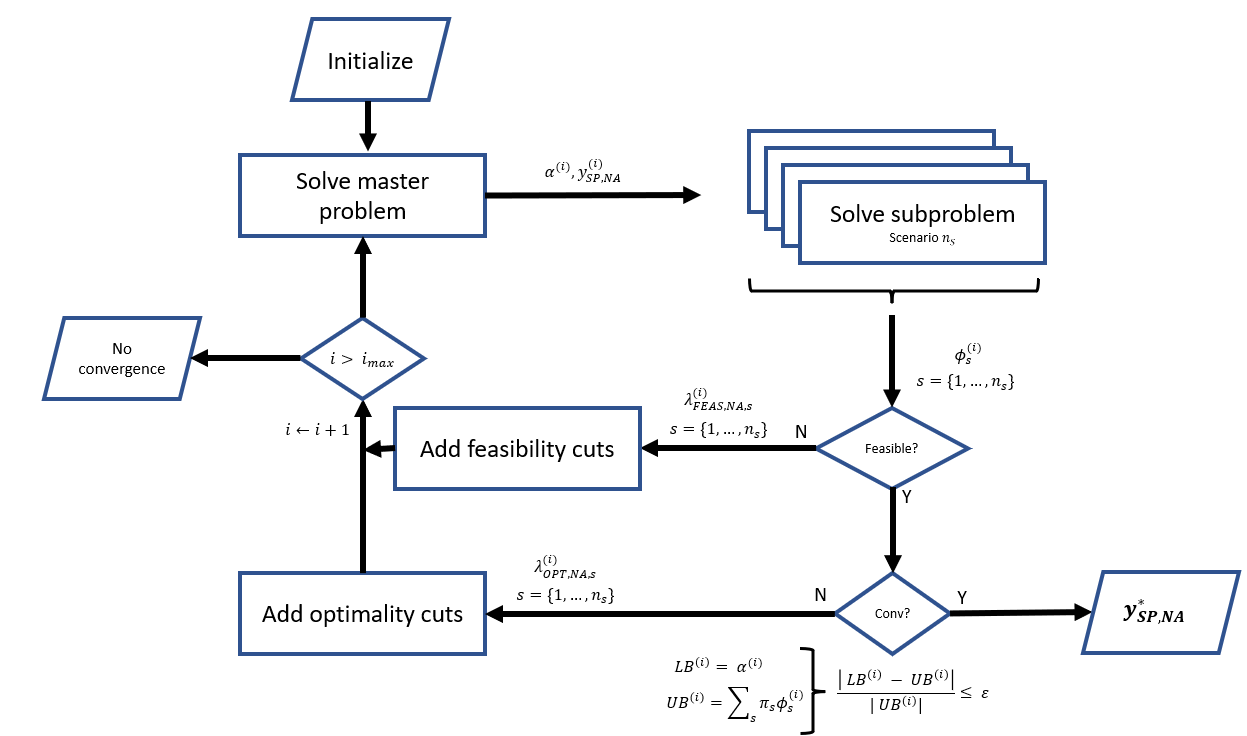
</div>

- Modeling Subproblem

In [11]:
function subp(yspFixed,C_0,P_0,u_0,xMPC_0,de_0,VmScen,pScen,rho_cc,solNom)    
    ###########
    # inputs: #
    ###########
    # yspFixed - setpoints determined by the master problem 
    # C_0, P_0 - substrate and biomass concentration at the current iteration (beginning of DRTO horizon)
    # u_0 - current input implemented in the plant
    # xMPC_0 - current MPC states
    # de_0 - current plant/MPC model deviation
    # VmScen - vector containing the values of the uncertain parameter for a given scenario
    # pScen - probability of a given scenario
    # rho_cc - objective function weight for cc relaxation
    # solNom - nominal solution
    
    # JuMP model
    model_sub = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model_sub, "warm_start_init_point", "yes")
    #set_optimizer_attribute(model_sub, "print_level", 5)
    set_optimizer_attribute(model_sub, "max_cpu_time", 300.0) # 5 min
    set_silent(model_sub)
    
     ####################
    # Set up variables #
    ####################
     # DRTO model variables
    @variable(model_sub, C[1:nfe, 1:ncp] ≥ 0.0)    # [g/L] substrate concentration (diff states)
    @variable(model_sub, P[1:nfe, 1:ncp] ≥ 0.0)    # [g/L] biomass concentration (diff states)
    @variable(model_sub, Cdot[1:nfe, 1:ncp])       # [g/L/h] substrate concentration (time derivative)
    @variable(model_sub, Pdot[1:nfe, 1:ncp])       # [g/L/h] biomass concentration (time derivative)
    @variable(model_sub, delta_p[1:nfe] ≥ 0.0)     # [g/L] soft constraint on P
    @variable(model_sub, 0.0 ≤ Cin[1:ndrto] ≤ Cin_max) # [g/L] substrate feed to reactor

    # MPC model variables (SISO) -> deviation form
    @variable(model_sub, xMPC[1:nx,1:ndrto])
    @variable(model_sub, uMPC[1:ndrto,1:m]) 

    # MPC <-> DRTO model deviation
    @variable(model_sub, de[1:(ndrto - 1)])

    # Constrained MPC KKT conditions (upper and lower bounds for each input)
    @variable(model_sub, mu_g[1:mD,1:(2*m)] ≥ 0, start = 0) 

    # setpoints for the controllers sent to the plant (*CL-DRTO degrees of freedom)
    @variable(model_sub, yspMin ≤ ysp[1:ndrto] ≤ yspMax)
    
    #####################################
    # Set up initial guesses for solver #
    #####################################
    if solNom isa Dict # if gives flexibility to NOT initialize variables
        for kk in 1:nfe
            for jj in 1:ncp
                set_start_value(C[kk,jj], solNom['C'][kk,jj,1])
                set_start_value(P[kk,jj], solNom['P'][kk,jj,1])
            end # collocation points loop
        end # end finite elements loop

        for kk in 1:ndrto
            # MV's
            set_start_value(Cin[kk], solNom['I'][kk,1])

            for mm in 1:m
                set_start_value(uMPC[kk,mm], solNom['I'][kk,1] - uref)
            end
        end
            
        for kk in 1:mD
            for mm in 1:(2*m)
                set_start_value(mu_g[kk,mm], solNom['μ'][kk,mm,1])
            end
        end # drto sampling time loop
    else
    # Set up initial guesses for solver: using opt. steady-state previoulsy computed
        for kk in 1:nfe
            for jj in 1:ncp
                set_start_value(C[kk,jj], C0) 
                set_start_value(P[kk,jj], P0)
            end # collocation points loop
        end # finite elements loop

        for kk in 1:ndrto
            # MV's
            set_start_value(Cin[kk], Cin0)

            for mm in 1:m
                set_start_value(uMPC[kk,mm], Cin0 - uref)
            end
        end 
    end
    
    ##############
    # DRTO model #
    ##############
    # [g/L/h] Immobilized enzyme or cell catalytic reaction rate (defined by Michaelis-Menten equation)
    @NLexpression(model_sub, rc[kk = 1:nfe, jj = 1:ncp], Vm_nom*C[kk,jj]/(Ks + C[kk,jj]))

    @NLconstraints(model_sub, begin
        #########
        # MODEL #
        #########    
        # reactor
        r_C[kk = 1:nfe, jj = 1:ncp], Cdot[kk,jj] == D*(Cin[cld(kk,n_fe_dt)] - C[kk,jj]) - rc[kk,jj] 
        r_P[kk = 1:nfe, jj = 1:ncp], Pdot[kk,jj] == rc[kk,jj] - D*P[kk,jj]
        #########################    
        # Collocation Equations #    
        #########################
        # initial point
        coll_C_0, C[1,1] == C_0 
        coll_P_0, P[1,1] == P_0  
        # set up collocation equations 
        coll_C_n[kk = 1:nfe, jj = 2:ncp], sum(colmat[ii,jj]*C[kk,ii] for ii in 1:ncp) - h*Cdot[kk,jj] == 0 
        coll_P_n[kk = 1:nfe, jj = 2:ncp], sum(colmat[ii,jj]*P[kk,ii] for ii in 1:ncp) - h*Pdot[kk,jj] == 0
        # continuinity equations
        coll_C_con[kk = 2:nfe], C[kk,1] - C[kk - 1,ncp] == 0 
        coll_P_con[kk = 2:nfe], P[kk,1] - P[kk - 1,ncp] == 0 
    end)

    ##########################
    # MPC model and solution #
    ##########################
    # N.B. inside MPC everything is in deviation variables
    @expressions(model_sub, begin
        cfT_1, (mpc['Ψ']*[xMPC_0;de_0] - (ysp[1:p] .- yref))'*mpc['Q']*mpc['Θ'] - (u0 - uref)*mpc['I']'*mpc['R']*mpc['M']
        cfT[kk = 1:(mD - 1)], (mpc['Ψ']*[xMPC[:,kk];de[kk]] - (ysp[(kk + 1):(kk + 1 + p - 1)] .- yref))'*mpc['Q']*mpc['Θ'] - uMPC[kk,1]*mpc['I']'*mpc['R']*mpc['M']
        # Input bounds
        MPC_u_upper[kk = 1:mD,uu = 1:m], (uMax - uref) - uMPC[kk,uu]
        MPC_u_lower[kk = 1:mD,uu = 1:m], uMPC[kk,uu] - (uMin - uref)
    end)

    @constraints(model_sub, begin
        #############
        # MPC model #
        #############
        MPC_dyn_model_1, xMPC[:,1] .== mpc['A']*xMPC_0 + mpc['B']*(u0 - uref)
        MPC_dyn_model[kk = 1:(ndrto - 1)], xMPC[:,kk + 1] .== mpc['A']*xMPC[:,kk] + mpc['B']*uMPC[kk,1]
        MPC_model_dev[kk = 1:(ndrto - 1)], de[kk] == (P[kk,ncp] - yref) - xMPC[2,kk]
        ################
        # MPC solution #
        ################
        # stationarity
        MPC_sol_sta_1, uMPC[1,:]'*mpc['H'] + cfT_1 +  mu_g[1,:]'*conMatrix .== 0
        MPC_sol_sta[kk = 1:(mD - 1)], uMPC[kk + 1,:]'*mpc['H'] + cfT[kk] +  mu_g[kk + 1,:]'*conMatrix .== 0
        # primal feasibility
        MPC_sol_feas_ub[kk = 1:mD,uu = 1:m], MPC_u_upper[kk,uu] ≥ 0
        MPC_sol_feas_lb[kk = 1:mD,uu = 1:m], MPC_u_lower[kk,uu] ≥ 0
    end)
    
    @constraints(model_sub, begin   
        ###############
        # CONSTRAINTS #
        ###############
        # ! Enforcing only at the end of the finite element
        # P soft constraints
        soft_P[kk = 1:nfe], P[kk,ncp] - delta_p[kk] ≤ pUB
        # fixing setpoint changes after mD
        control_horizon[kk = (mD+1):ndrto,uu = 1:m], uMPC[kk,uu] == uMPC[mD,uu]
        ############################
        # OPTIMIZATION CONSTRAINTS #
        ############################
        # connecting the MPC solution to the DRTO model (only the first element of the MV* is implemented)
        hc[kk = 1:ndrto], (uMPC[kk,1] + uref) - Cin[kk] == 0.0
        ##################################
        # NON-ANTICIPATIVITY CONSTRAINTS #
        ##################################
        nonAnt[kk = 1:Δdrto], ysp[kk] - yspFixed[kk] == 0.0
    end)
    
    # Set up objective function      
    @NLobjective(model_sub, Min, pScen*(sum((P[kk,ncp] - pTrack)^2 + wP*delta_p[kk]^2 for kk in 1:nfe)
    + rho_cc*sum(mu_g[kk,uu]*MPC_u_upper[kk,uu] + mu_g[kk,m + uu]*MPC_u_lower[kk,uu] for uu = 1:m, kk = 1:mD)))
    
    #################
    # Solve Problem #
    #################    
    optimize!(model_sub)
    
    # solution time
    timeSol = solve_time(model_sub)
    
    status = termination_status(model_sub)
    #display(status)
    
    # checking if there is a solution to the problem
    if status == MOI.ALMOST_LOCALLY_SOLVED || status == MOI.LOCALLY_SOLVED
        # Proved optimality or Optimal within relaxed tolerances
        # we add an optimality cut
        flag = 1
        # #primal_status(m)

        #calling values of the solved problem
        ϕ = objective_value(model_sub)
        yspArray = value.(ysp)
        CArray = value.(C)
        PArray = value.(P)
        CinArray = value.(Cin)
        
        muArray = value.(mu_g)
        
        # lagrange multipliers associated with the nonantecipativity constraints
        λ = dual.(nonAnt)
        
        outputDict = Dict('ϕ' => ϕ,
                        't' => timeSol,
                        'f' => flag, 
                        'a' => status,
                        's' => yspArray,
                        'I' => CinArray,
                        'C' => CArray,
                        'P' => PArray, 
                        'μ' => muArray,
                        'λ' => λ)
        
        return outputDict
    else
        #i.e. no feasible solution --> Add feasibility cut
        #display("Feasibility cut: scenario $(scen)")        
        
        # ! soft bounds on ysp
        delete_lower_bound.(ysp[1:pD])
        delete_upper_bound.(ysp[1:pD])
           
        # ! soft bounds on u
        delete(model_sub, MPC_sol_feas_ub)
        delete(model_sub, MPC_sol_feas_lb)
        unregister(model_sub, :MPC_sol_feas_ub)
        unregister(model_sub, :MPC_sol_feas_lb)
        
        ####################
        # Set up variables #
        ####################    
        # slack variables
        @variable(model_sub, delta_ysp_u[1:ndrto] ≥ 0.0)
        @variable(model_sub, delta_ysp_l[1:ndrto] ≥ 0.0)
        @variable(model_sub, delta_u_u[1:mD,1:m] ≥ 0.0)
        @variable(model_sub, delta_u_l[1:mD,1:m] ≥ 0.0)
        
        ###########################
        # Always-feasible problem #
        ###########################        
        @constraint(model_sub, soft_ysp_upper[kk = 1:ndrto], ysp[kk] - yspMax ≤ delta_ysp_u[kk])
        @constraint(model_sub, soft_ysp_lower[kk = 1:ndrto], yspMin - ysp[kk] ≤ delta_ysp_l[kk])
        @constraint(model_sub, soft_u_upper[kk=1:mD,uu=1:m], u[kk,uu] - (uMax - u0) ≤ delta_u_u[kk,uu])
        @constraint(model_sub, soft_u_lower[kk=1:mD,uu=1:m], (uMin - u0) - u[kk,uu] ≤ delta_u_l[kk,uu])
        
       #############################
        # Set up objective function #
        #############################
        # Modifying the objective --> minimizing constraint violation
        @objective(model_sub, Min, sum(delta_p[kk] for kk in 1:nfe) 
            + sum(delta_ysp_u[kk] + delta_ysp_l[kk] for kk in 1:ndrto)
            + sum(delta_u_u[kk,uu] + delta_u_l[kk,uu] for uu in 1:m, kk in 1:mD))
      

        #@show sub
        # re-optimizing (now using the always feasible problem)
        optimize!(model_sub)
        
        # objective function of the feasibility problem
        o = objective_value(model_sub)

        # solution time (adding time to solve the always feasible subproblem)
        timeSol = solve_time(model_sub)
        
        # checking status of the solution
        status_sub = termination_status(model_sub)
        
        # flag for calling feasibility cuts (not optimality cuts)
        flag = 0
        
        #calling values of the solved problem
        yspArray = value.(ysp)
        CinArray = value.(Cin)
        CArray = value.(C)
        PArray = value.(P)
        muArray = value.(mu_g)
        
        #slacks
#         dysp_ub = value.(delta_ysp_u)
#         dysp_lb = value.(delta_ysp_l)
#         temp1 = sum(dysp_ub[kk] + dysp_lb[kk] for kk in 1:ndrto)
#         display("DB: SP slacks sum: $(temp1)")
        
#         dc_ub = value.(delta_u_u)
#         dc_lb = value.(delta_u_l)
#         temp2 = sum(sum(dc_ub[kk,uu] + dc_lb[kk,uu] for uu in 1:m) for kk in 1:mD)
#         display("DB: MPC input slacks sum: $(temp2)")
        
        # lagrange multipliers associated with the nonantecipativity constraints
        λ = dual.(nonAnt)
        
        outputDict = Dict('ϕ' => o,
                        't' => timeSol,
                        'f' => flag, 
                        'a' => status_sub,
                        's' => yspArray,
                        'I' => CinArray,
                        'C' => CArray,
                        'P' => PArray,
                        'μ' => muArray,
                        'λ' => λ)
        
        return outputDict
    end
end;

- Modeling Master problem

In [12]:
## Modeling Benders Decompostion
function BENS_CLDRTO(C_0,P_0,u_0,xMPC_0,de_0,VmTemp,ns,rho_cc,solNom)
    ###########
    # inputs: #(xInit,uInit,nReac,nScen,pScen,solNom,option)
    ###########
    # C_0, P_0 - substrate and biomass concentration at the current iteration (beginning of DRTO horizon)
    # u_0 - current input implemented in the plant
    # xMPC_0 - current MPC states
    # de_0 - current plant/MPC model deviation
    # VmTemp - vector containing all the values of the uncertain parameter (Vm)
    # ns - number of scenarios
    # rho_cc - objective function weight for cc relaxation
    # solNom - nominal solution
    
    # saving opt gap array
    optGapArray = Vector{Float64}()
    
    # Assuming equiprobable scenarios
    pScen = 1.0/ns
    
    # flag for checking if last cut was opt. (1) or feas. (0)
    flagO = 1
    
    # timing solution via Benders
    timeSolBen = 0 
    # timing solution via parallel Benders
    timeSolParBen = 0 
    
    # Define master problem model
    master = Model(Ipopt.Optimizer)
    set_silent(master)
    
    #lower bound on scenario objective function approximation 
    alpha_down = 0.0; 
    
    # defining temp solution to avoid loop's scope
     ysp_nonⁱ = Vector{Float64}(undef,Δdrto)
    
    ####################
    # Set up variables #
    ####################
    # setpoints for the controllers sent to the plant
    @variable(master, yspMin ≤ ysp[1:Δdrto] ≤ yspMax)
    @variable(master, α ≥ alpha_down)
    
    ################################################
    # Solving problem with benders' decomposition  #
    ################################################
    for ii in 1:benIterMax
        
        ########################
        # Set up initial guess #
        ########################
        # check size of the optimality gap array
        s_opt_array = size(optGapArray)
        
        # always use nominal solution in the first iteration
        if ii == 1 
            for kk in 1:Δdrto
                set_start_value(ysp[kk], solNom['s'][kk,1])
            end 
        # check if MASTER problem got stuck in a solution, in this case use random guess   
        elseif s_opt_array[1] > 1 && abs(optGapArray[end] - optGapArray[end - 1]) < 0.001
            tempGuess = rand(Uniform(yspMin,yspMax),Δdrto)
            display("DB: random")

            for kk in 1:Δdrto
                set_start_value(ysp[kk], tempGuess[kk])
            end  
        # otherwise use previous solution
        else    
            for kk in 1:Δdrto
                set_start_value(ysp[kk],  ysp_nonⁱ[kk])
            end 
        end
          
        #############################
        # Set up objective function #
        #############################
        # "nudge" next solution towards nominal solution (working = 1e-4)
        @objective(master, Min, α + η_n*sum((ysp[kk] - solNom['s'][kk,1])^2 for kk in 1:Δdrto))
        
        # solve master problem (with Benders' cut)
        optimize!(master)

        # solution time
        timeSolMaster = solve_time(master)
        # extracting solution for the non-anticipativity constraints
        ysp_nonⁱ = value.(ysp) 
        
        # Master problem solution: lower bound of the original problem
        lb = value(α)
        
        timeSolBen = timeSolBen + timeSolMaster
        timeSolParBen = timeSolParBen + timeSolMaster # master cannot be paralellized 

        #######################
        # Solving subproblems #
        #######################
        # objective function
        o_temp = Vector{Float64}(undef,ns)
        # flag optimality / feasibility
        flag_temp = Vector{Float64}(undef,ns)
        # solution time
        solTime_temp = Vector{Float64}(undef,ns)
        # multipliers
        lambdaN_temp = Matrix{Float64}(undef,Δdrto,ns)
        
        for ss in 1:ns
            dicTemp = subp(ysp_nonⁱ,C_0,P_0,u_0,xMPC_0,de_0,VmTemp[ss],pScen,rho_cc[ss],solNom)

            # saving files
            # objective function
            o_temp[ss] = dicTemp['ϕ']
            # solution time
            solTime_temp[ss] = dicTemp['t']
            # optimality / feasibility flag
            flag_temp[ss] = dicTemp['f']
            # multiplier
            for kk in 1:Δdrto
                lambdaN_temp[kk,ss] = dicTemp['λ'][kk]
            end
        end
        
        ##########################################################
        # If all subproblems were feasible, check optimality gap #
        ##########################################################
        if sum(flag_temp) == ns 
            # Subproblem solution: upper bound of the original problem
            ub = sum(o_temp)

            # solve subproblems to find the upper bound of the original problem solution 
            timeSolBen = timeSolBen + sum(solTime_temp)

            # assuming that subproblem solution is parallelized
            timeSolParBen = timeSolParBen + maximum(solTime_temp)   
            
            # compute optimality gap
            gap = abs(ub - lb)/abs(ub)
            display("DB: opt. gap $(gap)")
            push!(optGapArray, gap)
            
            # check if optimality gap is small enough
            # also, make sure last cut was an optimality cut due to change in OF 
            if gap < optGap && flagO == 1
                global yspSol_dec = ysp_nonⁱ
                global objFun_dec = ub
                global optGap_dec = gap
                global iter_dec = ii
                global time_dec = timeSolBen
                global time_max_dec = timeSolParBen
                break
            else # gap ≥ optGap 
                ##############################
                # --> adding optimality cuts #
                ##############################
                display(">>>>>> iteration $(ii):O")
                benderscutO = @constraint(master, α ≥ ub + 
                    sum(sum(lambdaN_temp[jj,ss] for ss in 1:ns)*(ysp[jj] - ysp_nonⁱ[jj]) for jj in 1:Δdrto))
                #@info "we are adding this bender optimality cut $(benderscutO)"
                
                # optimality cut was add
                flagO = 1
            
            end # if gap
        else # sum(flag_temp) != nScen
            ###############################
            # --> adding feasibility cuts #
            ###############################
            display(">>>>>> iteration $(ii):F")
            benderscutF = @constraint(master, 0 ≥
                sum(sum(lambdaN_temp[jj,ss] for ss in 1:ns)*(ysp[1,jj] - ysp_nonⁱ[1,jj]) for jj in 1:Δdrto))
            #@info "we are adding this bender feasibility cut $(benderscutF)"
            
            # feasibility cut was add
            flagO = 0
            
        end # if nScen
        
        # checking if number of iterations reached max 
        if ii < benIterMax
            global yspSol_dec = [NaN for kk=1:Δdrto]
            global objFun_dec = NaN
            global optGap_dec = NaN
            global iter_dec = benIterMax
            global time_dec = timeSolBen
            global time_max_dec = timeSolParBen
        end # if < benIterMax
    end # if for benders iterations

    #####################
    # Extracting values #
    #####################
    if isnan(objFun_dec)
        
        outputFun = Dict('t' => timeSolBen,
                         'ϕ' => objFun_dec,
                         'τ' => time_max_dec, 
                         'i' => iter_dec,
                         'd' => yspSol_dec,
                         'g' => optGap_dec,
                         'o' => optGapArray)
                        
        
        return outputFun
        
    else
        CinArray = Matrix{Float64}(undef,ndrto,ns)
        PArray = Array{Float64}(undef,nfe,ncp,ns)
        CArray = Array{Float64}(undef,nfe,ncp,ns)
        yspArray = Matrix{Float64}(undef,ndrto,ns)

        for ss in 1:ns
            dicTemp = subp(yspSol_dec,C_0,P_0,u_0,xMPC_0,de_0,VmTemp[ss],pScen,rho_cc[ss],solNom)

            # saving files
            CinArray[:,ss] = dicTemp['I']
            PArray[:,:,ss] = dicTemp['P']
            CArray[:,:,ss] = dicTemp['C']
            yspArray[:,ss] = dicTemp['s']
        end

        #calling values of the solved problem    
        outputFun =  Dict('ϕ' => objFun_dec,
                    't' => time_dec,
                    'τ' => time_max_dec, 
                    'i' => iter_dec,
                    'd' => yspSol_dec,
                    'g' => optGap_dec,
                    'I' => CinArray,
                    'P' => PArray,
                    'C' => CArray,
                    's' => yspArray,
                    'o' => optGapArray)  
        
        return outputFun

    end
end;

<a id="sec3"></a>

# Checking the performance of the methods in terms of time vs. nScen

Getting the solution for the nominal scenario

In [13]:
# building MPC's
# reactor 1 MPC: T1 <-> Q1
mpc = MPC_matrices(A,B,C,p,m,q,r)

solNom = MS_CLDRTO(C0,P0,u0,xMPC0,de0,Vm_nom,1,1e3,0);
display("DB: nominal problem flag: $(solNom['f'])")


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



"DB: nominal problem flag: 1"

In [14]:
# testing the number of scenarios
nScenMax = 25 # 5 / 10 / 30

#preparing plot 
# --> monolithic vs. decomposed 
# solution time
solTimeTraj_s = Matrix{Float64}(undef,2,nScenMax - 1) 
# computed objective function
solObjTraj_s = Matrix{Float64}(undef,2,nScenMax - 1) 
# --> only decomposed
# max solution time over all scenarios 
solTimeMaxTraj_s = Vector{Float64}(undef,nScenMax - 1) 
# number of iterations
iterTraj_s = Vector{Float64}(undef,nScenMax - 1) 
# optimality gap
optGapTraj_s = Vector{Float64}(undef,nScenMax - 1) 

for ss = 2:nScenMax
    display("evaluating $(ss) scenarios")

    # creating uncertain parameter array
    pUnc = LinRange(pNom - deltaPar,pNom + deltaPar, ss)
    
    # same weight for each scenario
    rho_cc_ss = 1e1*ones(1,ss)
    
    # solving monolithical problem 
    sol_m_Dict = MS_CLDRTO(C0,P0,u0,xMPC0,de0,pUnc,ss,rho_cc_ss,solNom)
    
    # solving decomposed problem
    sol_d_Dict = BENS_CLDRTO(C0,P0,u0,xMPC0,de0,pUnc,ss,rho_cc_ss,solNom)
    
    # for plotting
    #display("DB: time M $(sol_m_Dict['t']) | time D $(sol_d_Dict['t'])")
    solTimeTraj_s[1,ss - 1] = sol_m_Dict['t']
    solTimeTraj_s[2,ss - 1] = sol_d_Dict['t']
    solObjTraj_s[1,ss - 1] = sol_m_Dict['ϕ']
    solObjTraj_s[2,ss - 1] = sol_d_Dict['ϕ']
    
    solTimeMaxTraj_s[ss - 1] = sol_d_Dict['τ']
    iterTraj_s[ss - 1] = sol_d_Dict['i'] 
    optGapTraj_s[ss - 1] = sol_d_Dict['g']
end;

"evaluating 2 scenarios"

"DB: opt. gap 1.0000000052636817"

">>>>>> iteration 1:O"

"DB: opt. gap 0.004310200082726145"

">>>>>> iteration 2:O"

"DB: opt. gap 9.186581540025667e-7"

"evaluating 3 scenarios"

"DB: opt. gap 1.000000005263681"

">>>>>> iteration 1:O"

"DB: opt. gap 0.00431106863840047"

">>>>>> iteration 2:O"

"DB: opt. gap 0.004100693448625671"

">>>>>> iteration 3:O"

"DB: random"

"DB: opt. gap 2.461620994851578e-6"

"evaluating 4 scenarios"

"DB: opt. gap 1.0000000052636795"

">>>>>> iteration 1:O"

"DB: opt. gap 0.004310266423003589"

">>>>>> iteration 2:O"

"DB: opt. gap 0.0039027046248234663"

">>>>>> iteration 3:O"

"DB: random"

"DB: opt. gap 1.1731185840393338e-5"

"evaluating 5 scenarios"

"DB: opt. gap 1.0000000052636786"

">>>>>> iteration 1:O"

"DB: opt. gap 0.00431001857598763"

">>>>>> iteration 2:O"

"DB: opt. gap 0.0039751157599970405"

">>>>>> iteration 3:O"

"DB: random"

"DB: opt. gap 6.961642953938563e-6"

"evaluating 6 scenarios"

"DB: opt. gap 1.0000000052636704"

">>>>>> iteration 1:O"

"DB: opt. gap 0.004309797051812076"

">>>>>> iteration 2:O"

"DB: opt. gap 0.004199961574530865"

">>>>>> iteration 3:O"

"DB: random"

"DB: opt. gap 7.155244304804951e-7"

"evaluating 7 scenarios"

"DB: opt. gap 1.0000000052636755"

">>>>>> iteration 1:O"

"DB: opt. gap 0.004309685096262583"

">>>>>> iteration 2:O"

"DB: opt. gap 0.004063623021278594"

">>>>>> iteration 3:O"

"DB: random"

"DB: opt. gap 3.751253211030781e-6"

"evaluating 8 scenarios"

"DB: opt. gap 1.0000000052636648"

">>>>>> iteration 1:O"

"DB: opt. gap 0.004309389320974069"

">>>>>> iteration 2:O"

"DB: opt. gap 0.004227245680392191"

">>>>>> iteration 3:O"

"DB: random"

"DB: opt. gap 3.824597395542871e-7"

"evaluating 9 scenarios"

"DB: opt. gap 1.0000000052636633"

">>>>>> iteration 1:O"

"DB: opt. gap 0.004309620967790146"

">>>>>> iteration 2:O"

"DB: opt. gap 0.004236183719254382"

">>>>>> iteration 3:O"

"DB: random"

"DB: opt. gap 5.054636521486778e-7"

"evaluating 10 scenarios"

"DB: opt. gap 1.0000000052636602"

">>>>>> iteration 1:O"

"DB: opt. gap 0.004309528712696281"

">>>>>> iteration 2:O"

"DB: opt. gap 0.0042431160328118755"

">>>>>> iteration 3:O"

"DB: random"

"DB: opt. gap 2.1859900423298692e-7"

"evaluating 11 scenarios"

"DB: opt. gap 1.0000000052636544"

">>>>>> iteration 1:O"

"DB: opt. gap 0.004308321632946016"

">>>>>> iteration 2:O"

"DB: opt. gap 0.004248223797114709"

">>>>>> iteration 3:O"

"DB: random"

"DB: opt. gap 1.4541495958078836e-7"

"evaluating 12 scenarios"

"DB: opt. gap 1.0000000052636553"

">>>>>> iteration 1:O"

"DB: opt. gap 0.004308891143850997"

">>>>>> iteration 2:O"

"DB: opt. gap 0.004253701134307786"

">>>>>> iteration 3:O"

"DB: random"

"DB: opt. gap 1.1816743171019678e-7"

"evaluating 13 scenarios"

"DB: opt. gap 1.0000000052636526"

">>>>>> iteration 1:O"

"DB: opt. gap 0.0043086980324626625"

">>>>>> iteration 2:O"

"DB: opt. gap 0.004257683872711644"

">>>>>> iteration 3:O"

"DB: random"

"DB: opt. gap 9.339283744202537e-8"

"evaluating 14 scenarios"

"DB: opt. gap 1.0000000052636717"

">>>>>> iteration 1:O"

"DB: opt. gap 0.004312710000985686"

">>>>>> iteration 2:O"

"DB: opt. gap 0.00426517443909166"

">>>>>> iteration 3:O"

"DB: random"

"DB: opt. gap 1.3624166461128037e-7"

"evaluating 15 scenarios"

"DB: opt. gap 1.0000000052636717"

">>>>>> iteration 1:O"

"DB: opt. gap 0.004315363925272637"

">>>>>> iteration 2:O"

"DB: opt. gap 0.0042686864039282214"

">>>>>> iteration 3:O"

"DB: random"

"DB: opt. gap 7.789314819796114e-8"

"evaluating 16 scenarios"

"DB: opt. gap 1.0000000052636708"

">>>>>> iteration 1:O"

"DB: opt. gap 0.004313234877246833"

">>>>>> iteration 2:O"

"DB: opt. gap 0.0042716698913252225"

">>>>>> iteration 3:O"

"DB: random"

"DB: opt. gap 2.507228022777182e-8"

"evaluating 17 scenarios"

"DB: opt. gap 1.0000000052636702"

">>>>>> iteration 1:O"

"DB: opt. gap 0.004313621926437079"

">>>>>> iteration 2:O"

"DB: opt. gap 0.004274287160862107"

">>>>>> iteration 3:O"

"DB: random"

"DB: opt. gap 1.4372657513888478e-7"

"evaluating 18 scenarios"

"DB: opt. gap 1.0000000052636688"

">>>>>> iteration 1:O"

"DB: opt. gap 0.0043134607835365315"

">>>>>> iteration 2:O"

"DB: opt. gap 0.004276561876651657"

">>>>>> iteration 3:O"

"DB: random"

"DB: opt. gap 1.5662298480679026e-7"

"evaluating 19 scenarios"

"DB: opt. gap 1.0000000052636668"

">>>>>> iteration 1:O"

"DB: opt. gap 0.004313374639687157"

">>>>>> iteration 2:O"

"DB: opt. gap 0.0042784710575392414"

">>>>>> iteration 3:O"

"DB: random"

"DB: opt. gap 2.3745065884720792e-7"

"evaluating 20 scenarios"

"DB: opt. gap 1.0000000052636666"

">>>>>> iteration 1:O"

"DB: opt. gap 0.004315000618154118"

">>>>>> iteration 2:O"

"DB: opt. gap 0.004280349715888125"

">>>>>> iteration 3:O"

"DB: random"

"DB: opt. gap 1.2512575451474285e-6"

"evaluating 21 scenarios"

"DB: opt. gap 1.0000000052636673"

">>>>>> iteration 1:O"

"DB: opt. gap 0.004314089441319053"

">>>>>> iteration 2:O"

"DB: opt. gap 0.004282170922247647"

">>>>>> iteration 3:O"

"DB: random"

"DB: opt. gap 6.034586835862453e-8"

"evaluating 22 scenarios"

"DB: opt. gap 1.0000000052636477"

">>>>>> iteration 1:O"

"DB: opt. gap 0.004311288187163236"

">>>>>> iteration 2:O"

"DB: opt. gap 0.0042802577914161505"

">>>>>> iteration 3:O"

"DB: random"

"DB: opt. gap 1.1015159411409815e-7"

"evaluating 23 scenarios"

"DB: opt. gap 1.0000000052636415"

">>>>>> iteration 1:O"

"DB: opt. gap 0.004309578460629511"

">>>>>> iteration 2:O"

"DB: opt. gap 0.00428060235398969"

">>>>>> iteration 3:O"

"DB: random"

"DB: opt. gap 1.338428847084683e-7"

"evaluating 24 scenarios"

"DB: opt. gap 1.0000000052636453"

">>>>>> iteration 1:O"

"DB: opt. gap 0.004310673320526293"

">>>>>> iteration 2:O"

"DB: opt. gap 0.004282767851665157"

">>>>>> iteration 3:O"

"DB: random"

"DB: opt. gap 2.0170841125584243e-8"

"evaluating 25 scenarios"

"DB: opt. gap 1.0000000052636409"

">>>>>> iteration 1:O"

"DB: opt. gap 0.0043102772118229155"

">>>>>> iteration 2:O"

"DB: opt. gap 0.0042833989095197745"

">>>>>> iteration 3:O"

"DB: random"

"DB: opt. gap 4.611626989522611e-8"

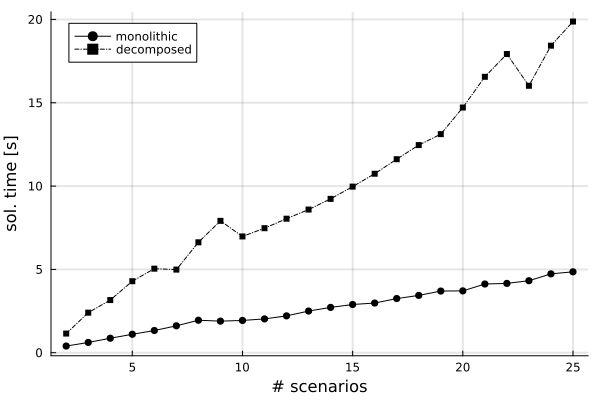

In [15]:
# solution time
p1 = plot(2:nScenMax,solTimeTraj_s[1,:],
    xlabel="# scenarios",
    ylabel="sol. time [s]",
    marker=:circle,
    markercolor = :black,
    linecolor = :black,
    label="monolithic")

p1 = plot!(2:nScenMax,solTimeTraj_s[2,:],
    marker=:square, 
    markercolor = :black,
    linecolor = :black,
    markersize = 3,
    linestyle = :dashdot,
    label="decomposed",
    gridlinewidth=2,
    dpi=600)

display(p1)
savefig(p1,"C:/Users/MACC-Jose/Documents/Canada/Papers/Benders Decomposition/Figures/C4_SolTime.pdf");

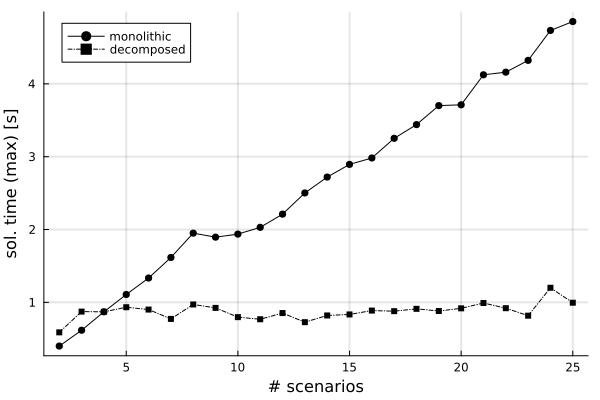

In [16]:
# solution time (parallel)
p1b = plot(2:nScenMax,solTimeTraj_s[1,:],
    xlabel="# scenarios", 
    ylabel="sol. time (max) [s]",
    marker=:circle, 
    markercolor = :black,
    linecolor = :black,
    label="monolithic")

p1b = plot!(2:nScenMax,solTimeMaxTraj_s,
    marker=:square, 
    markercolor = :black,
    linecolor = :black,
    markersize = 3,
    linestyle = :dashdot,
    label="decomposed",
    gridlinewidth=2,
    dpi=600)

display(p1b)
savefig(p1b,"C:/Users/MACC-Jose/Documents/Canada/Papers/Benders Decomposition/Figures/C4_SolTimePar.pdf");

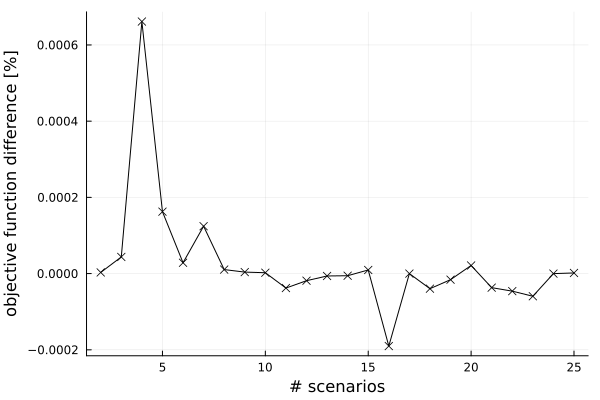

In [17]:
# objective function (parallel)
p2 = plot(2:nScenMax,100*(solObjTraj_s[2,:] - solObjTraj_s[1,:])./solObjTraj_s[1,:],
    xlabel="# scenarios", 
    ylabel="objective function difference [%]",
    marker=:xcross, 
    markercolor = :black,
    linecolor = :black,
    label="",
    dpi=600)

display(p2)
savefig(p2,"C:/Users/MACC-Jose/Documents/Canada/Papers/Benders Decomposition/Figures/C4_OFComp.pdf");

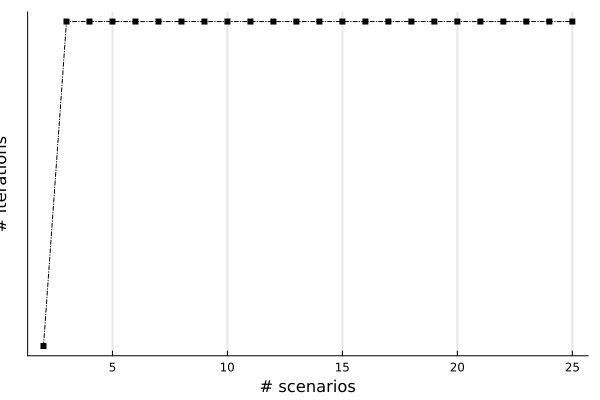

In [18]:
p3 = plot(2:nScenMax,iterTraj_s,xlabel="# scenarios", ylabel="# iterations",
    marker=:square, 
    markersize=3,
    linecolor = :black,
    markercolor = :black,
    linestyle = :dashdot,
    label="",
    yticks=range(0,150,step=10),
    gridlinewidth=2,
    dpi=600)

display(p3)
#savefig(p3,"C:/Users/MACC-Jose/Documents/Canada/Papers/Benders Decomposition/Figures/C4_BenIter.pdf");

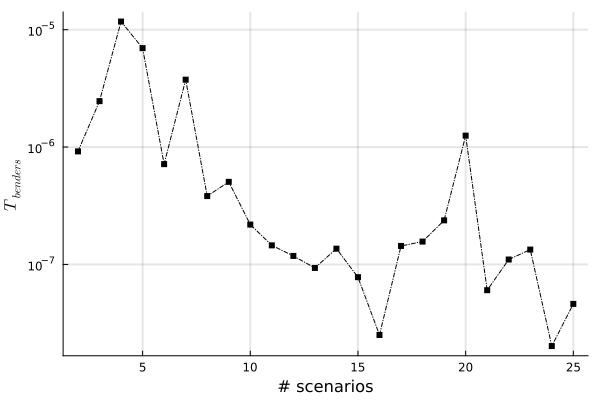

In [19]:
p4 = plot(2:nScenMax,optGapTraj_s,
    yscale=:log10,
    xlabel="# scenarios", 
    ylabel=L"T_{benders}",
    marker=:square, 
    markersize=3,
    linecolor = :black,
    markercolor = :black,
    linestyle = :dashdot,
    label="",
    gridlinewidth=2,
    dpi=600)

display(p4)
#savefig(p4,"C:/Users/MACC-Jose/Documents/Canada/Papers/Benders Decomposition/Figures/C4_BenOptGap.pdf");

<a id="sec4"></a>

# Checking if trajectories match
- arbitrarily chosen number of scenarios

In [20]:
nSCheck = 3 # number of scenarios

# Extracting solution for plotting --> monolithic vs. decomposed 
CTraj = Array{Float64}(undef,2,nfe,nSCheck)
PTraj = Array{Float64}(undef,2,nfe,nSCheck)
CinTraj = Array{Float64}(undef,2,ndrto,nSCheck)
yspTraj = Array{Float64}(undef,2,ndrto,nSCheck) 

#equiprobable scenarios
pScheck = 1.0/nSCheck

# Regularized CC function 
rho_cc_check = [1e1 1e1 1e1]

# creating uncertain parameter array
pCheck = LinRange(pNom - deltaPar,pNom + deltaPar, nSCheck)

sol_mon = MS_CLDRTO(C0,P0,u0,xMPC0,de0,pCheck,nSCheck,rho_cc_check,solNom)
display("DB: monolithic problem flag: $(sol_mon['f'])")
sol_dec = BENS_CLDRTO(C0,P0,u0,xMPC0,de0,pCheck,nSCheck,rho_cc_check,solNom);

"DB: monolithic problem flag: 1"

"DB: opt. gap 1.000000005263681"

">>>>>> iteration 1:O"

"DB: opt. gap 0.00431106863840047"

">>>>>> iteration 2:O"

"DB: opt. gap 0.004100693448625671"

">>>>>> iteration 3:O"

"DB: random"

"DB: opt. gap 2.4616594152865194e-6"

Preparing plot

In [21]:
# Number of subplots 
num_subplots = nSCheck

# Creating color array
CList = reshape( range(colorant"red", stop=colorant"blue",length=nSCheck), 1, nSCheck);
MList =[:square, :circle];

# time vector
t_drto = Vector{Float64}(undef,ndrto) 
for kk in 1:ndrto
    t_drto[kk] = dt*kk
end

t_fe = Vector{Float64}(undef,nfe) 
for kk in 1:nfe
    t_fe[kk] = h*kk
end


# data arrays
for ss in 1:nSCheck
    # Extracting values
    CTraj[1,:,ss] = sol_mon['C'][:,ncp,ss]
    PTraj[1,:,ss] = sol_mon['P'][:,ncp,ss]
    CinTraj[1,:,ss] = sol_mon['I'][:,ss]
    yspTraj[1,:,ss] = sol_mon['s'][:,ss] 
    
    CTraj[2,:,ss] = sol_dec['C'][:,ncp,ss]
    PTraj[2,:,ss] = sol_dec['P'][:,ncp,ss]
    CinTraj[2,:,ss] = sol_dec['I'][:,ss]
    yspTraj[2,:,ss] = sol_dec['s'][:,ss] 
 end;

Plotting Recipe

In [22]:
@userplot Plot_Comp
@recipe function f(h::Plot_Comp)
        
if length(h.args) < 5
        y_lim, ylab, x, y = h.args
    else
        y_lim, ylab, x, y, y_ub = h.args
    end
    
    # set up the subplots
    # these are common to both marginal histograms
    layout := (3,1)
    grid := true
    gridlinewidth --> 2
    latex := true
    linecolor := :black
    
    for ss = 1:3
        # limits
        ylimits := y_lim
        
        # labels 
        ylabel := ylab
        if ss == 3
            xlabel := "time [min]"
        end
        
        # DATA PLOTTING
        # upper bound
        if length(h.args) > 4 
            # lower bound
            @series begin
                seriestype := :path
                linestyle := :dot
                subplot := ss
                label --> ""
                
                x, y_ub*ones(length(x))
            end
        end

        labels = ["Mono.", "Deco."]
        for mm = 1:2
            # average MC value
            @series begin
                seriestype := :path
                linewidth := 3
                subplot := ss

                markercolor := :black
                markerstrokecolor := :black
                markersize := 3

                if ss == 1
                    label --> labels[mm]
                else
                    label --> ""
                end

                if mm == 1
                    linestyle := :solid
                    markershape := :circle
                else
                    linestyle := :dashdot
                    markershape := :rect
                end

                x, y[mm,:,ss]
            end
        end
    end # mono/dec loop
end;

- Substrate Concentration

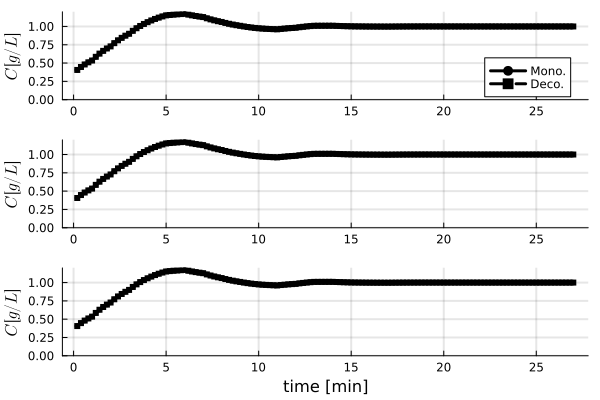

In [23]:
plot_comp((0.0,1.2),L"C [g/L]",t_fe,CTraj)

- Biomass Concentration

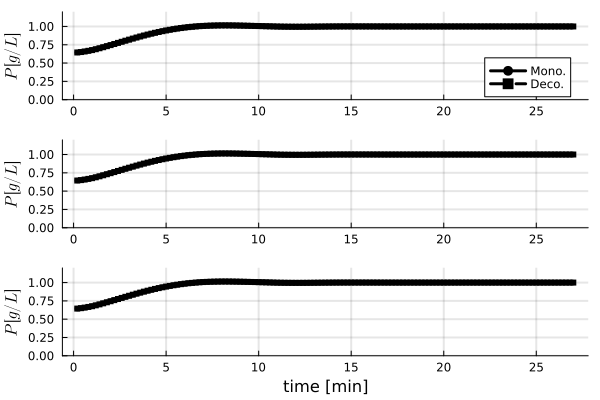

In [24]:
plot_comp((0.0,1.2),L"P [g/L]",t_fe,PTraj)

- Biomass Setpoint

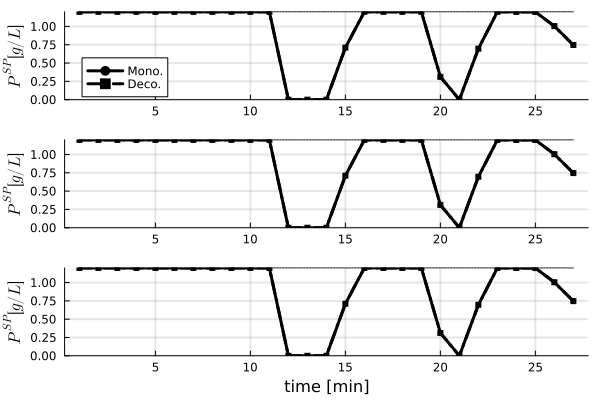

In [25]:
plot_comp((yspMin,yspMax),L"P^{SP} [g/L]",t_drto,yspTraj,yspMax)

- Inputs

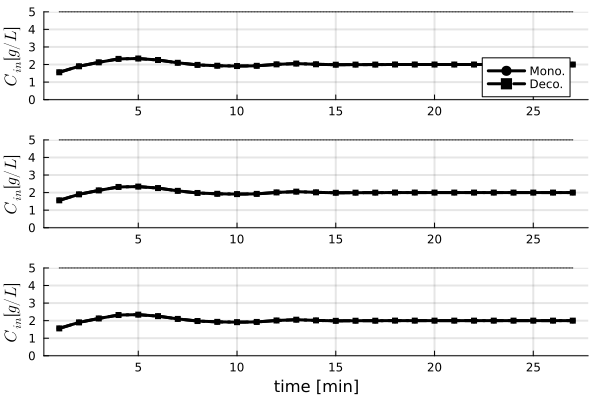

In [26]:
plot_comp((0.0,Cin_max),L"C_{in} [g/L]",t_drto,CinTraj,Cin_max)

Creating table to show the results

In [30]:
# Scenarios
table_iter = Any[]
table_solTime_M = Any[]
table_solTime_D = Any[]
table_solMax = Any[]
table_of_M = Any[]
table_of_D = Any[]
table_perChange = Any[]

for tt in [4 9 14 19 24] 
    push!(table_iter, tt)
    push!(table_solTime_M, solTimeTraj_s[1,tt])
    push!(table_solTime_D, solTimeTraj_s[2,tt])
    push!(table_solMax, solTimeMaxTraj_s[tt])
    push!(table_of_M, solObjTraj_s[1,tt])
    push!(table_of_D, solObjTraj_s[2,tt])
    push!(table_perChange, 100*(solObjTraj_s[2,tt] - solObjTraj_s[1,tt])/solObjTraj_s[1,tt])
end

df_scen = DataFrame(; iter = table_iter, 
                sol_time_M = table_solTime_M, 
                 sol_time_D = table_solTime_D,
                 sol_time_D_max = table_solMax,
                 comp_of_M = table_of_M,
                 comp_of_D = table_of_D,
                 per_change = table_perChange);

In [31]:
display("Analysis: # of Scenarios")
display(df_scen)

"Analysis: # of Scenarios"

Row,iter,sol_time_M,sol_time_D,sol_time_D_max,comp_of_M,comp_of_D,per_change
,Any,Any,Any,Any,Any,Any,Any
1,4,1.108,4.292,0.933,1.33955,1.33955,0.000162535
2,9,1.937,6.978,0.797,1.33955,1.33955,2.31191e-6
3,14,2.894,9.968,0.833999,1.33955,1.33955,9.49942e-6
4,19,3.712,14.713,0.918,1.33956,1.33956,2.13016e-5
5,24,4.855,19.874,0.995,1.33956,1.33956,1.70268e-6


# NOTES: